# CNN + Data Augmentation 練習

In [ ]:
#家銘手刻augmentation0.8

In [2]:
pip install pandas

  Using cached pandas-1.2.0-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
  Using cached pytz-2020.5-py2.py3-none-any.whl (510 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
# Check GPU
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# import package
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv2D,
                                     MaxPooling2D)

## Where AM I 資料讀入及前處理

先觀察一下 Where AM I 資料夾的結構<br>
可以看出是
>資料集  /datasets/aia-data2020/where_am_i
>>訓練集  /train

>>>類別<br>
>>>/CALsuburb<br>
/PARoffice<br>
...

In [7]:
data_path = "train/"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots, each))
            y_data_list.append(roots.split("/")[-1])

In [8]:
img_size = 224

(224, 224)


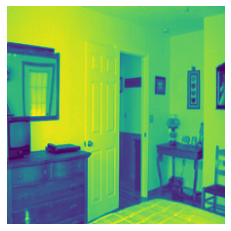

In [9]:
img = cv2.imread(x_data_list[2], 0)
img = cv2.resize(img, (img_size, img_size))
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
def load_img(data_list):
    data_img = []
    for each in tqdm(data_list):
        img = cv2.imread(each, 0)
        img = cv2.resize(img, (img_size, img_size))
        data_img.append(img[..., np.newaxis])

    return np.array(data_img).astype('float32')/255.

In [11]:
x_data = load_img(x_data_list)

100%|██████████| 2985/2985 [00:08<00:00, 345.45it/s]


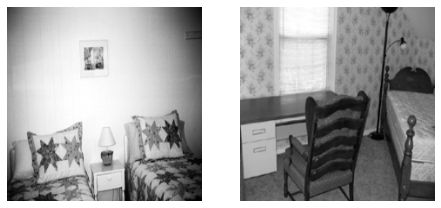

In [12]:
# show image
plt.figure(figsize=(16, 8))
for i in range(2):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_data[i][..., 0], cmap='gray')
    plt.axis('off')
plt.show()

In [13]:
y_data_list = pd.DataFrame(y_data_list, columns=['label'])
uniques = y_data_list['label'].value_counts().index
counts = y_data_list['label'].value_counts().values

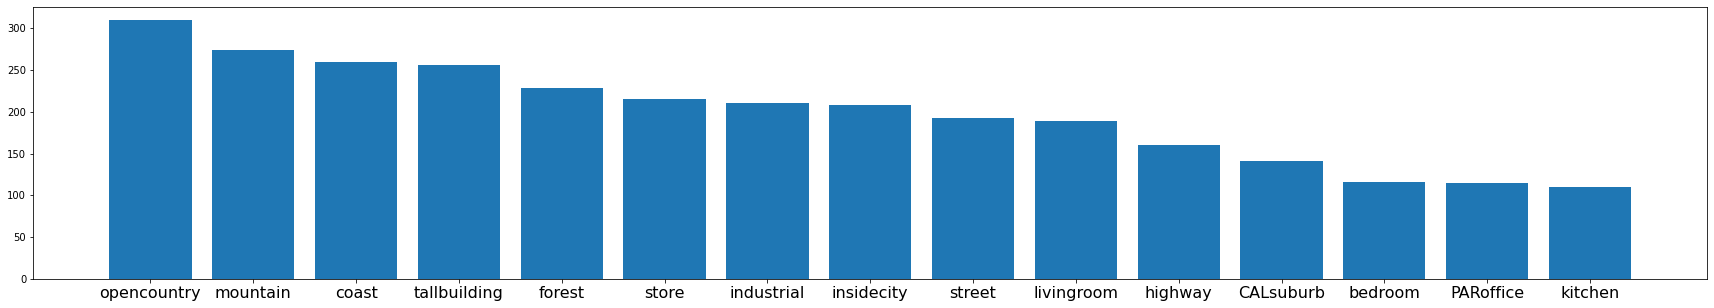

In [14]:
plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

In [15]:
class_path = "/datasets/aia-data2020/where_am_i/"
class_map = pd.read_csv(os.path.join(class_path, 'mapping.txt'),
                        header=None, index_col=0)
class_map = class_map.to_dict()[1]

In [16]:
y_data = y_data_list['label'].map(class_map).values.copy()

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.1,
                                                    random_state=10,
                                                    stratify=y_data)

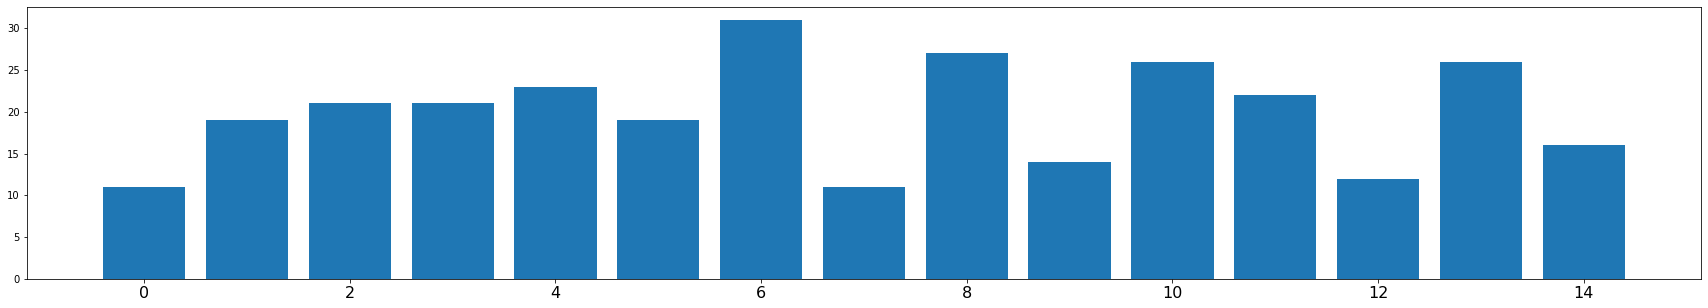

In [18]:
uniques, counts = np.unique(y_test, return_counts=True)

plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

In [19]:
num_classes = len(uniques)

y_train = np.eye(num_classes, dtype='float32')[y_train]
y_test = np.eye(num_classes, dtype='float32')[y_test]
print('y_train shape:', y_train.shape)

y_train shape: (2686, 15)


## 模型定義

In [20]:
from tensorflow.keras import initializers
from tensorflow.keras.layers import GlobalAveragePooling2D
initial = initializers.he_normal()

In [21]:
inputs = Input(shape=x_train.shape[1:])

x = Conv2D(32, (3, 3), padding='same', kernel_initializer=initial)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = Conv2D(64, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = Conv2D(128, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = Conv2D(128, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.1)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0     

In [23]:
learning_rate = 0.001
optimizer = keras.optimizers.Adam(lr=learning_rate)
batch_size = 32
epochs = 50

In [24]:
# initiate optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Data Augmentation

## 開始訓練模型 (Data augmentation 參數設置)

In [25]:
model_dir = './Model/model-logs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

LR_decay = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                        patience=3,
                                                        verbose=1,
                                                        factor=0.5)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=10,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, LR_decay, earlystop]

In [26]:
num_step = x_train.shape[0] // batch_size
from sklearn.utils import class_weight
classes_to_predict = sorted(np.unique(y_train.argmax(-1)))
class_weights = class_weight.compute_class_weight("balanced", classes_to_predict, y_train.argmax(-1))
class_weights_dict = {i : class_weights[i] for i,label in enumerate(classes_to_predict)}

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], y=[10 14 11 ... 13  9  5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [27]:
datagen = ImageDataGenerator(
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False,
                             fill_mode='nearest',
                             cval=0,
                         )


history = model.fit(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=num_step,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    class_weight=class_weights_dict,
                    callbacks=callbacks_list
                            )

Epoch 1/50
83/83 [==============================] - 13s 151ms/step - loss: 2.1715 - accuracy: 0.2871 - val_loss: 4.5653 - val_accuracy: 0.1304 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - 11s 138ms/step - loss: 1.6278 - accuracy: 0.4642 - val_loss: 4.1265 - val_accuracy: 0.1137 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - 12s 139ms/step - loss: 1.3423 - accuracy: 0.5731 - val_loss: 3.0869 - val_accuracy: 0.2140 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - 12s 141ms/step - loss: 1.2197 - accuracy: 0.6051 - val_loss: 1.9211 - val_accuracy: 0.3645 - lr: 0.0010
Epoch 5/50
83/83 [==============================] - 12s 139ms/step - loss: 1.1009 - accuracy: 0.6447 - val_loss: 1.8686 - val_accuracy: 0.4548 - lr: 0.0010
Epoch 6/50
83/83 [==============================] - 12s 139ms/step - loss: 1.0077 - accuracy: 0.6575 - val_loss: 1.6586 - val_accuracy: 0.5351 - lr: 0.0010
Epoch 7/50
83/83 [==============================] - 11s 138ms/st

## 訓練結果視覺化

In [28]:
model = load_model('./Model/model-logs/basic_model-best-model.h5')
loss, acc = model.evaluate(x_test, y_test, verbose=2)

10/10 - 0s - loss: 0.4139 - accuracy: 0.8863


In [29]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(-1)

In [30]:
class_names = np.array([each for each in class_map.keys()])

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test.argmax(-1), y_pred))
print(confusion_matrix(y_test.argmax(-1), y_pred))

0.8862876254180602
[[10  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  1  0  0  0  0  0  2  0  0  0]
 [ 0  2  0 19  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0 15  0  0  0  0  0  1  2  0  0]
 [ 0  0  0  0  1  0 25  0  1  0  4  0  0  0  0]
 [ 1  0  0  0  0  0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  1  0 20  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0  0  0 19  1  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  0  0 10  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  1  0  0  0  1  0  1  0  0  0  0  0 13]]


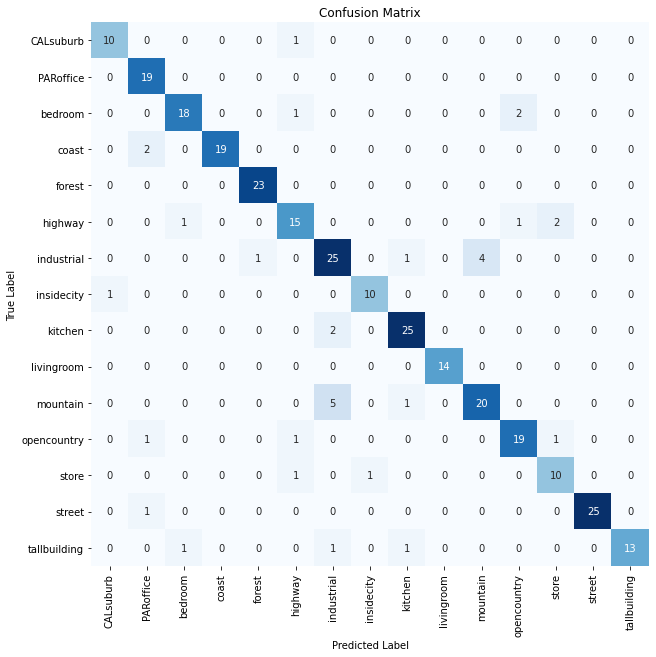

In [32]:
import seaborn as sns

matrix = confusion_matrix(y_test.argmax(-1), y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [33]:
import pandas as pd
submission = pd.read_csv('img-submission.csv')
test_id = submission.id
test_path = "test/"
test_list = []
for file in test_id:
    test_list.append(os.path.join(test_path, file)+'.jpg')
test_data = load_img(test_list)

100%|██████████| 1500/1500 [00:03<00:00, 472.72it/s]


In [34]:
y_pred = model.predict(test_data)
y_pred = y_pred.argmax(-1)

submission['class'] = y_pred
submission.to_csv('20210116.csv', index=False)